In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
import matplotlib
import itertools
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
# Gloabal Constants
pass_file = "/mnt/data/mvesc/pgpass" # username, db information

# Table names
sqlcmd_table_names = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

Tab_CurrentStudents = "CurrentStudents"
Tab_AllDis1112 = "AllDistricts1112"
Tab_AllDis1213 = "AllDistricts1213"
Tab_AllDis1314 = "AllDistricts1314"
Tab_AllDis1515 = "AllDistricts1415"

# The table names in a string, from Jackie
ALL_DISTRICTS_TABLES = ["AllDistricts" + str(num-1) + str(num) for num in range(15,11, -1)]
ALL_DISTRICTS_TABLES.insert(0, "CurrentStudents")
# ['CurrentStudents', 'AllDistricts1112', 'AllDistricts1213', 'AllDistricts1314', 'AllDistricts1415']

Tab_HSGrades = "HSGrades"

In [3]:
# Set up connection to postgres database
with open(pass_file, 'r') as f:
    passinfo = f.read()
passinfo = passinfo.strip().split(':')

host_address = passinfo[0]
user_name = passinfo[2]
name_of_database = passinfo[3]
user_password = passinfo[4]
connection = pg.connect(host=host_address, database=name_of_database, user=user_name, password=user_password)
table_names = pd.read_sql(sqlcmd_table_names, connection)
print(table_names)

                  table_name
0          DistrictSchoolIDs
1                 all_lookup
2            CurrentMobility
3            CurrentStudents
4              ASQ_Preschool
5                  ActScores
6           AllDistricts1112
7                   HSGrades
8           AllDistricts1213
9                  AIRScores
10          AllDistricts1314
11  CurrentAbsenceDiscipline
12                  DIBELSv2
13          AllDistricts1415
14             AllGradsTotal
15                    OAAOGT
16                     PARCC
17                  StarRead
18                    StarEL
19                  StarMath
20                 TerraNova


In [4]:
# functions explore a table
def get_column_names(table, connection):
    """
    Get column names of a table 
    
    :param pg.extensions.connection object connection: sql connection
    :param string table: table name in the database
    :rtype: list 
    """
    temp_table = pd.read_sql("select * FROM \"%s\" limit 1" % table, connection)
    return list(temp_table.columns)

def read_table_to_df(table_name, connection, maxStudentLookup=1e6):
    """ from Jackie
    Takes a table name as input and returns postgres table as pandas data frame.
    
    :param string table_name: Name of table to read in
    :param psycopg2.connection connection: POSTGRESQL connection object for Python
    :return: a Pandas dataframe object containing the desired table
    :rtype: Pandas.dataframe
    """
    sql_query = "SELECT * FROM \"" + table_name + "\" limit " + str(int(maxStudentLookup)) + ";"
    data = pd.read_sql(sql_query, connection)
    return data

def different_columns(table1, table2, connection):
    """ find different columns names of two tables
    
    :param string table1: name of table 1
    :param string table2: name of table 2
    :param pg.connection connection: sql connection
    :return: a list with 2 sets of different columns names in 2 tables
    :rtype: list[set, set]
    """
    columns1 = get_column_names(table1, connection)
    columns2 = get_column_names(table2, connection)
    diff_col1 = set(columns1) - set(columns2)
    diff_col2 = set(columns2) - set(columns1)
    return([diff_col1, diff_col2])

def generate_colnames(schoolyear='1415'):
    """ generate the colnames based on the shcool year, e.g. 1415
    
    :para string schoolyear: school year, e.g. 1415
    :return: a list of columns names
    :rtype: list[string]
    """
    columns_name_base = ['StudentLookup', 'CURRENT_GRADE', 'HANDICAP', 'HANDICAP_DESC', 'DISADVANTAGEMENT', 'DISADVANTAGEMENT_DESC', 'DATE_OF_BIRTH', 'STUDENT_STATUS', 'STUDENT_STATUS_DESC', 'GENDER', 'RACIAL_ETHNIC_DESC', 'LIMITED_ENGLISH', 'GIFTED', 'ADMISSION_DATE', 'PERCENT_ATTEND', 'DAYS_IN_ATTENDANCE', 'DAYS_ABSENT', 'TARDY', 'PERCENT_ATTEND', 'DAYS_IN_ATTENDANCE', 'DAYS_ABSENT', 'TARDY', 'DISC_INCIDENTS', 'IN_SCHOOL_SUSP', 'OUT_OF_SCHOOL_SUSP', 'EXPUL', 'District', 'School']
    current_year=int(schoolyear[-2:]) # last 2 characters of a table name
    year_append1 = "_20"+str(current_year-2)+"_"+str(current_year-1)
    year_append2 = "_20"+str(current_year-3)+"_"+str(current_year-2)
    year_append = [year_append1]*4 + [year_append2]*4 + [year_append1]*4
    col_append = ['']*14 + year_append + ['']*2
    columns = [columns_name_base[i]+col_append[i] for i in range(len(columns_name_base))]
    return(columns)

In [5]:
# Read all the data in a list 
# Old district data's first column ReCounter is dropped
NumStudent2Load = 1e6
all_districts_data = [read_table_to_df(table_name, connection, NumStudent2Load).iloc[:, 1:] for table_name in ALL_DISTRICTS_TABLES[1:]]
all_districts_data.insert(0, read_table_to_df(ALL_DISTRICTS_TABLES[0], connection, NumStudent2Load))

In [14]:
# double check columns to see if they have the same structure
### What I learnt: the 5 tables have the same column names and data types ###
""" # check if tables have the same columns 
list_all_district_data_cols = [list(df.columns) for df in all_districts_data]
pd.DataFrame(np.transpose(np.array(list_all_district_data_cols)), columns=ALL_DISTRICTS_TABLES)
"""

''' # check if tables have the same data types
dtypes_all_districts_data=[[type(all_districts_data[i][col][0]) for col in all_districts_data[i].columns] for i in range(5)]
pd.DataFrame(np.transpose(np.array(dtypes_all_districts_data)), columns=ALL_DISTRICTS_TABLES)
'''

# check the data types for all columns
# pd.DataFrame(np.transpose([list_all_district_data_cols[0], dtypes_all_districts_data[0]]), columns=['AllDistrictTable_columns', 'data_types'])


' # check if tables have the same data types\ndtypes_all_districts_data=[[type(all_districts_data[i][col][0]) for col in all_districts_data[i].columns] for i in range(5)]\npd.DataFrame(np.transpose(np.array(dtypes_all_districts_data)), columns=ALL_DISTRICTS_TABLES)\n'

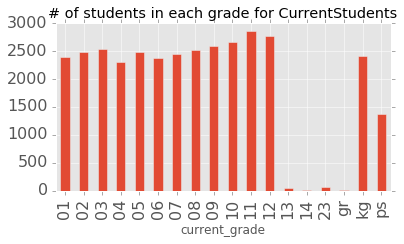

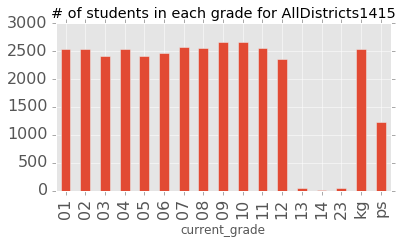

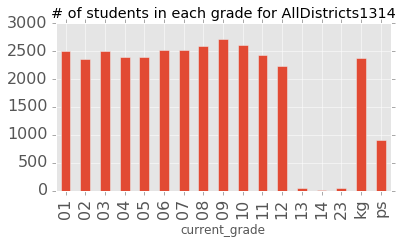

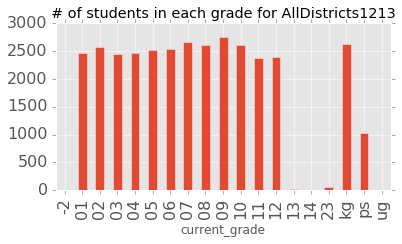

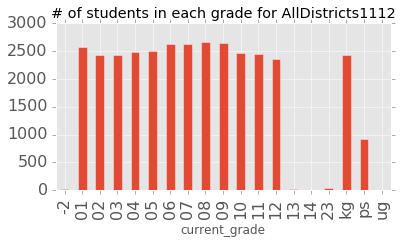

In [6]:
def get_distinct_counts(col, connection, table):
    """ get the number of dintinct values
    
    :param string col: column name
    :param pg.connection connection: sql connection
    :param string table: table name
    :return dataframe: data frame of distinct counts
    :rtype pandas.dataframe
    """
    cmd = "select lower(\"%s\") as %s, count(*) from \"%s\" group by lower(\"%s\") order by count(*) desc" % (col, col, table, col)
    df = pd.read_sql(cmd, connection)
    return df

def plot_group_counts(table, col, title='', out_rows=[], figsize=(6, 3)):
    """ get the number of students for each group
    
    :param string col: column name
    :param pg.connection connection: sql connection
    :param string table: table name
    :param list out_rows: rows of values to rule out 
    :return dataframe: data frame of distinct counts
    :rtype pandas.dataframe
    """
    df = get_distinct_counts(col, connection, table)
    col = col.lower()
    df.index = df[col]
    row2keep = [row not in out_rows for row in df.iloc[:,0]]
    df = df.iloc[row2keep, :]
    df = df.sort_values([col])
    plt.figure()
    df['count'].plot(kind='bar', title=title + " for " + table, figsize=figsize, fontsize=16)

col='CURRENT_GRADE'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each grade')
    
### What I learnt: most students are in grade from 01 to 12
### Questions:??? what is -2, 13, 14, 23, GR, KG, PS
###:Cleanup: remove Grade '-2'

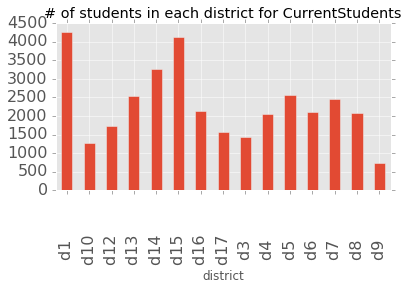

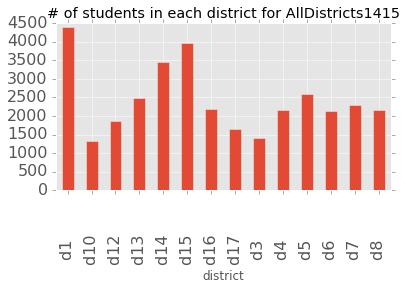

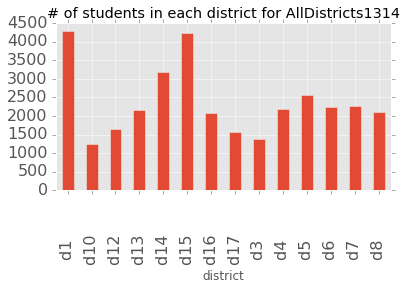

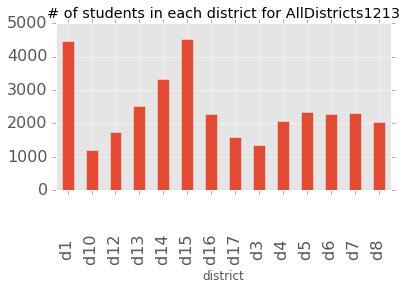

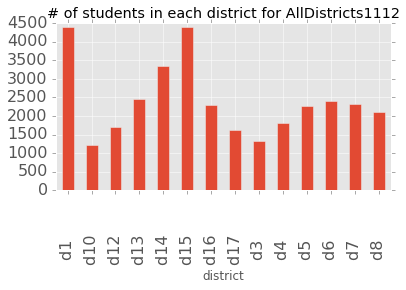

In [8]:
col='District'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each district')
    
### What I learnt: similar distributions; d9 is missing in AllDistrictData
### Questions:
### Cleanup: not much to do

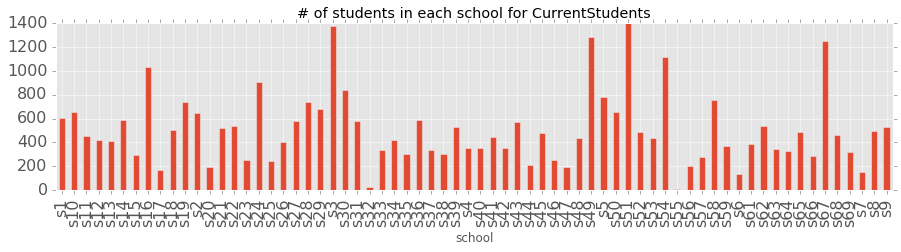

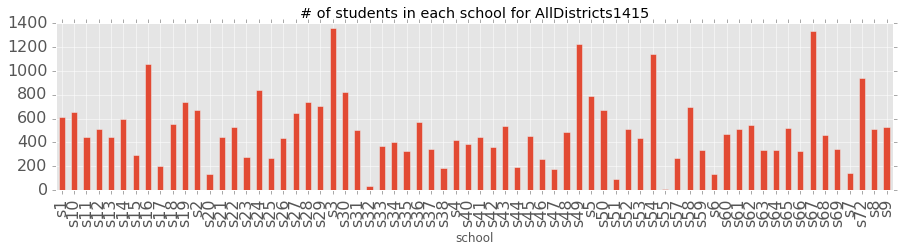

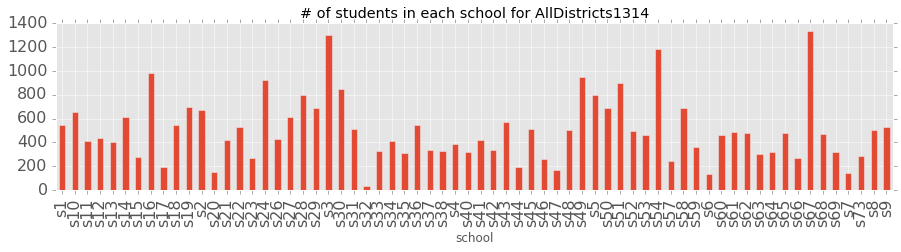

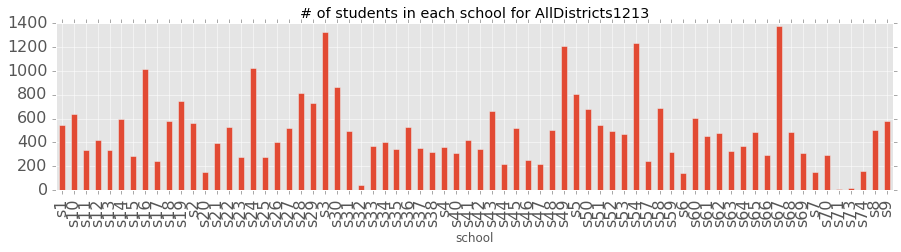

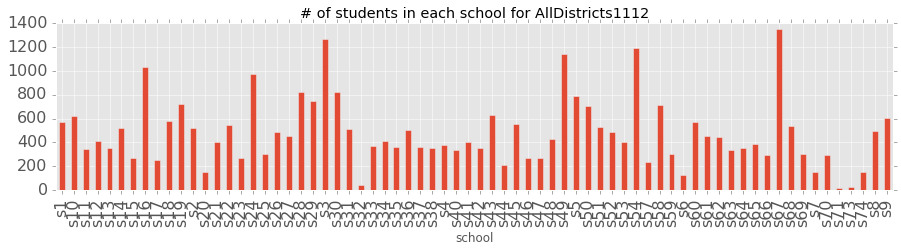

In [9]:
col='School'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students in each school', out_rows=[], figsize=(15,3))
    
### What I learnt: students in schools has similar distributions
### Questions:
### Cleanup: not much to do for this 

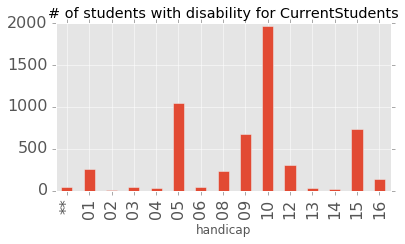

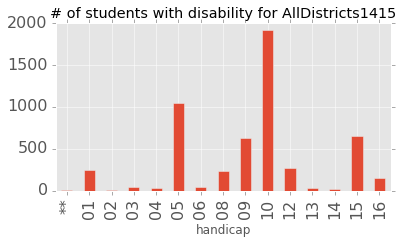

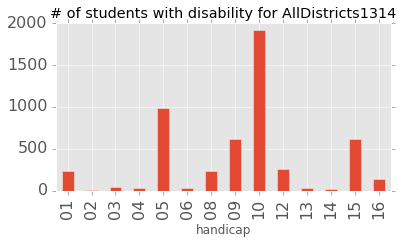

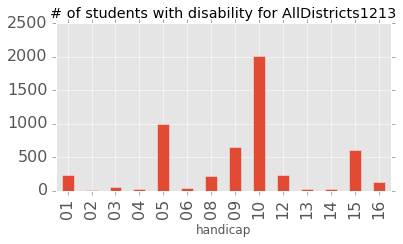

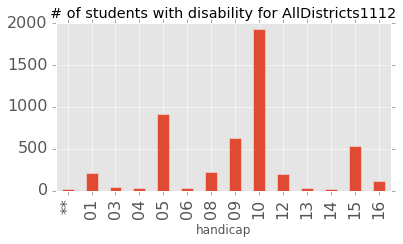

In [10]:
col='HANDICAP'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students with disability', out_rows=[''])
    
### what I learnt: similar distribution of "HANDICAP"; **, 02 has very few students; it could be a feature, maybe 2 classes
### Questions:??? **, 02 has no description
### cleanup: remove **, 05-Speech&Language, 13-Traumatic, some has code but no desc, some has desc but no code

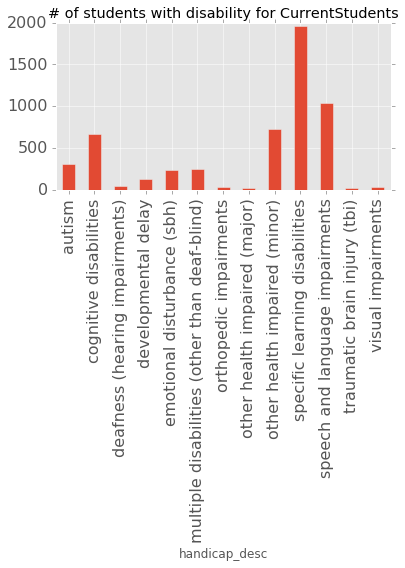

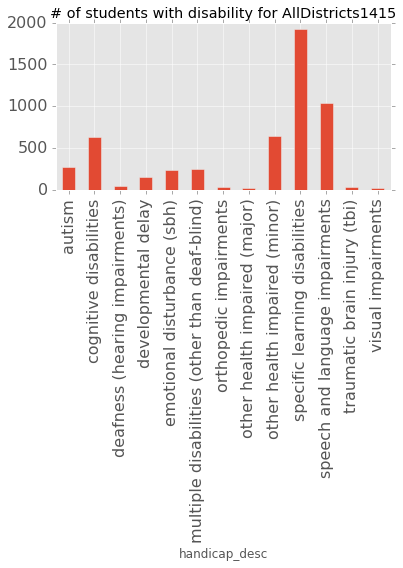

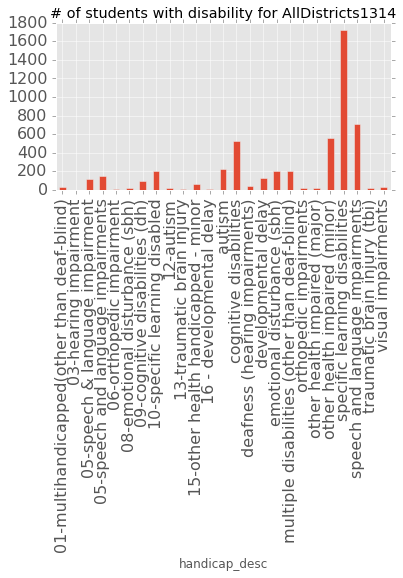

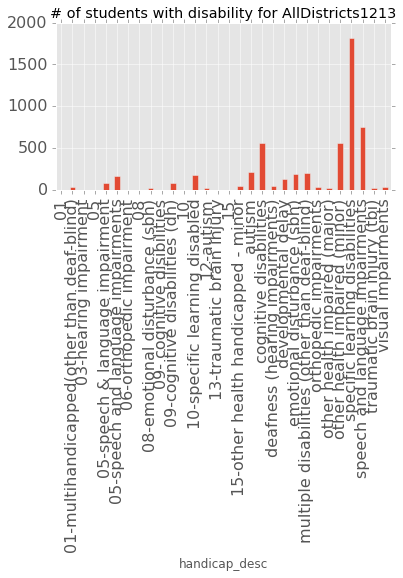

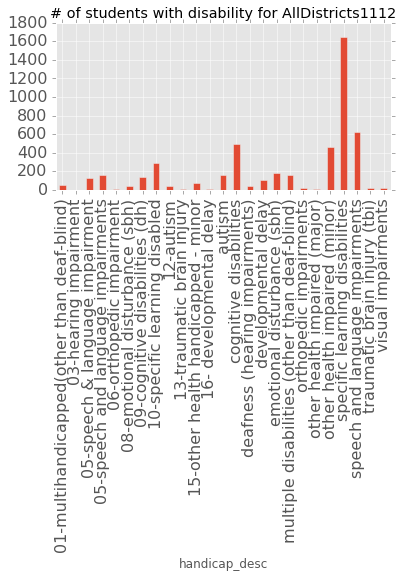

In [11]:
col='HANDICAP_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students with disability', out_rows=[''])
    
# What I learnt: very messy, code and desc are not consistent, some rows either code or desc are missing
# Question:
# cleanup: clean up the code and desc and redirect them to the right one for consistence

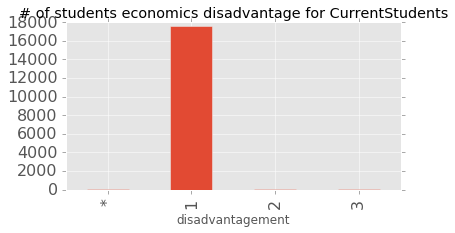

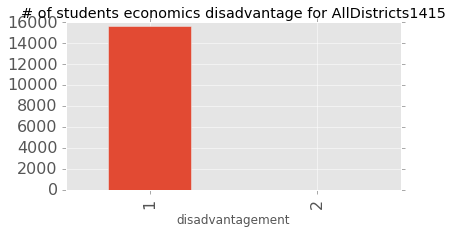

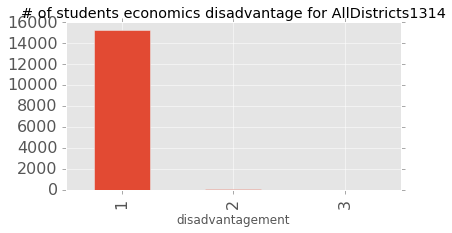

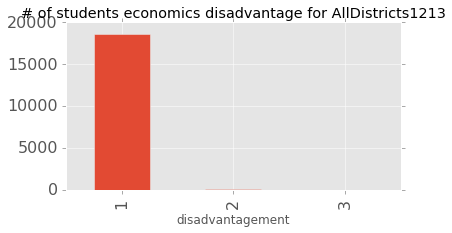

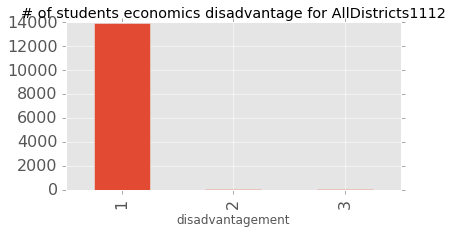

In [12]:
col='DISADVANTAGEMENT'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students economics disadvantage', out_rows=[''])
    
### what I learnt: Economic, Academic, Economic and Academic; could be a feature, only 3 classes, 
### Questions:??? blank code with Academic Disadvantages, 1-Economic, 2-AcademicDis, 25 * in currentstudent
### Clean up !!!: make code and desc consistent, Economic, *, blank code with Academic Disadvantages, 1-Economic, 2-AcademicDis, remove *'s

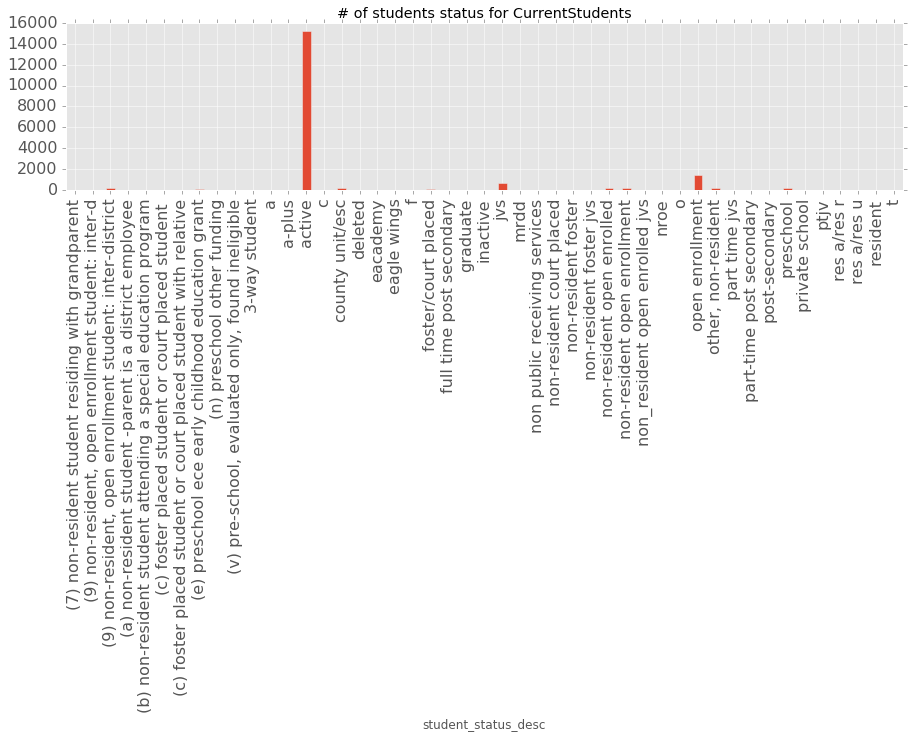

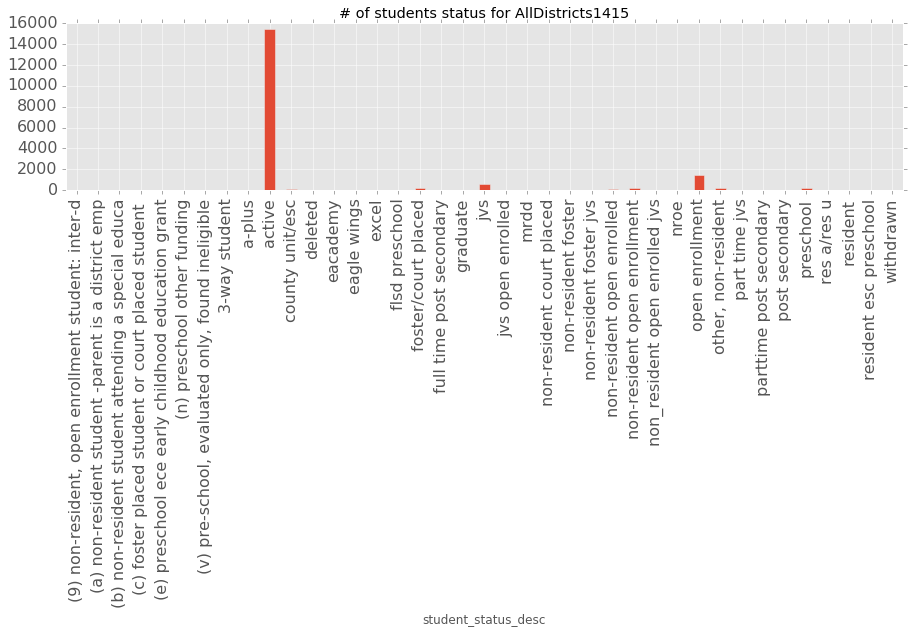

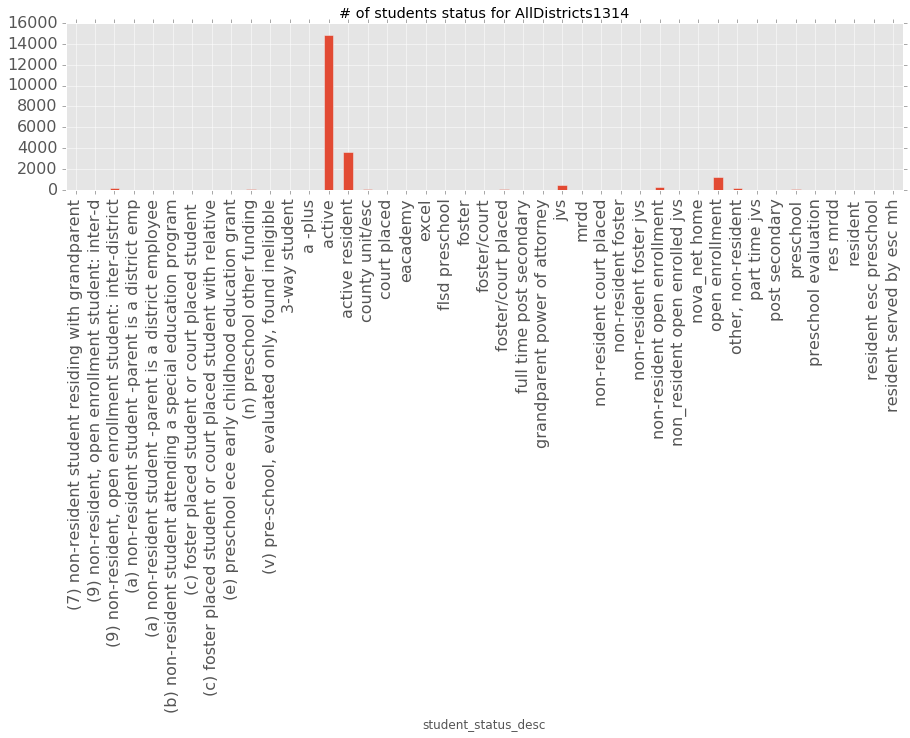

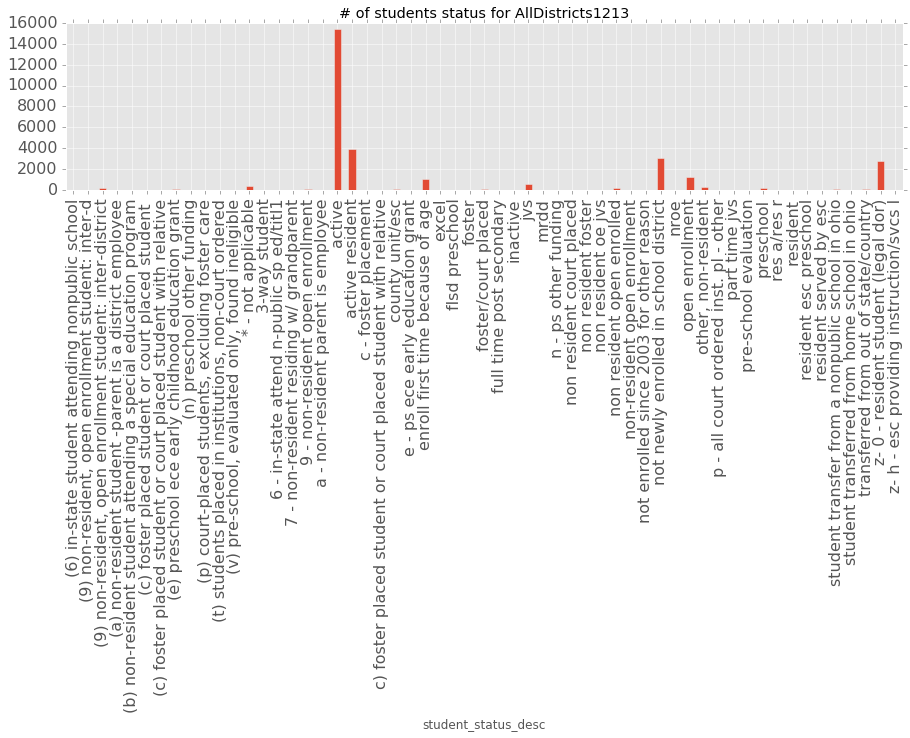

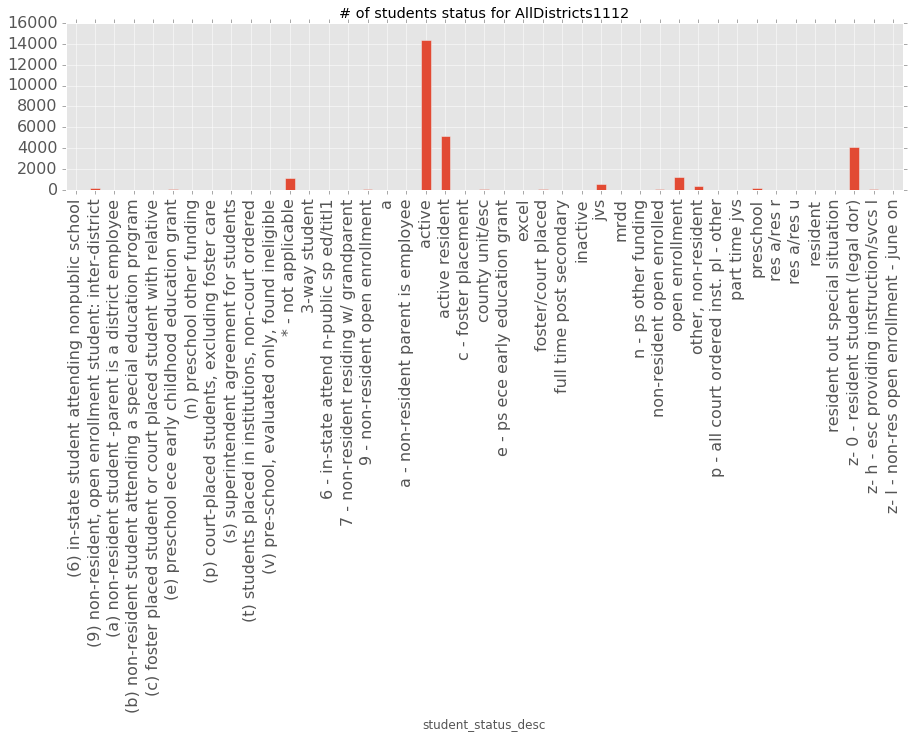

In [13]:
col='STUDENT_STATUS_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students status', out_rows=[''], figsize=(15, 3))
    
# what I learnt: very very messy, many categories
# Questions: 
# Cleanup: one of status or desc may be missing, code and desc may be in the same column

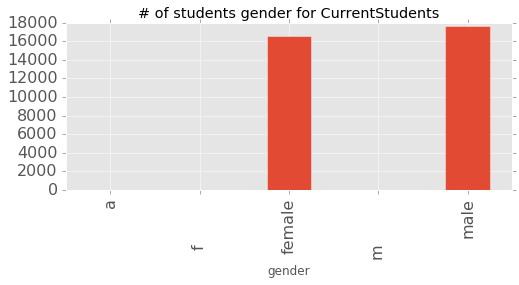

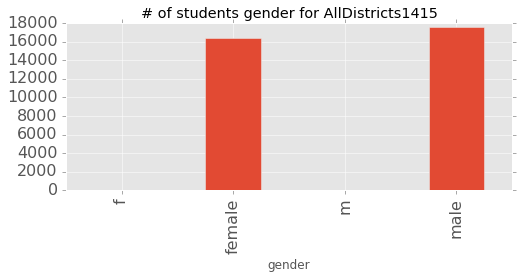

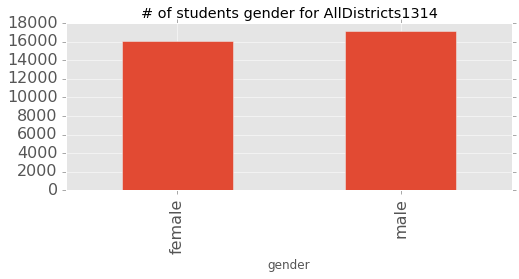

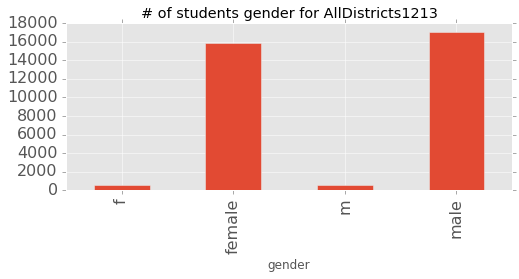

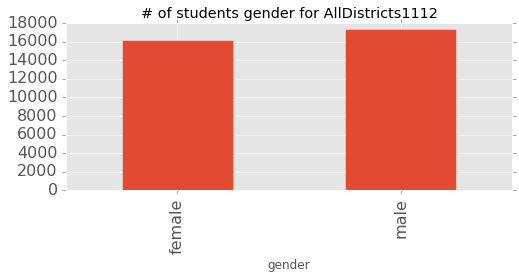

In [14]:
col='GENDER'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students gender', out_rows=[''], figsize=(8, 3))
    
# what I learnt: Gender; could be a feature 
# Questions: 
# Cleanup: lower/upper case; F-> female; M-> male;

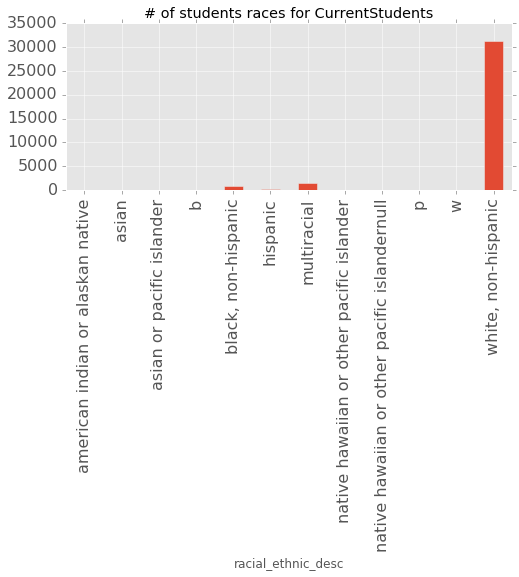

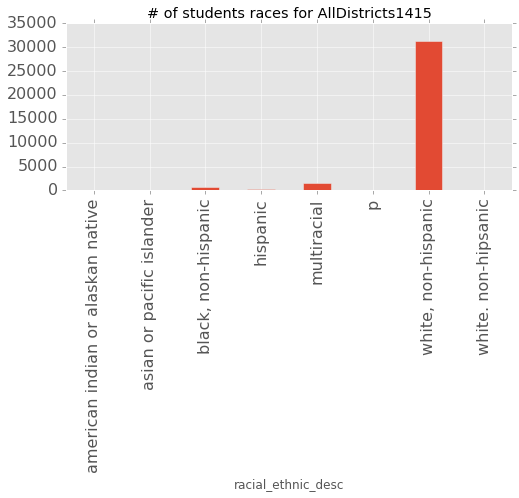

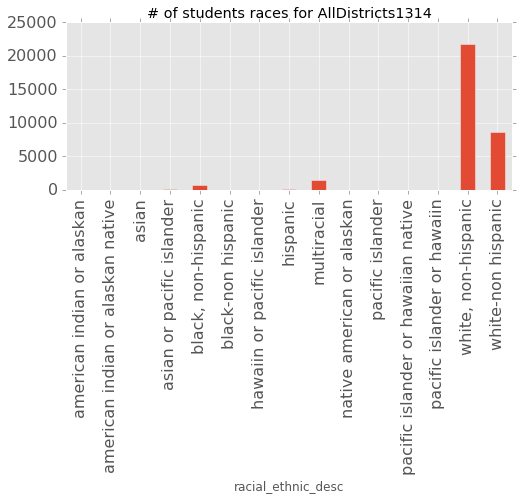

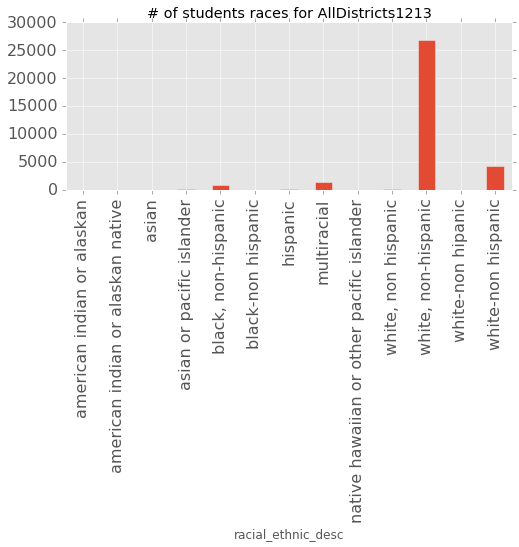

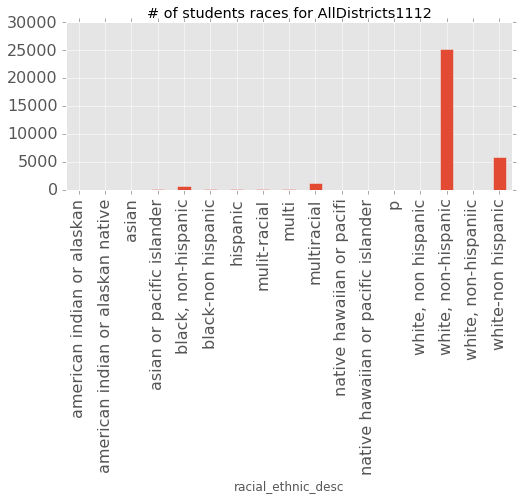

In [15]:
col='RACIAL_ETHNIC_DESC'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students races', out_rows=[''], figsize=(8, 3))
    
# what I learnt: 
# Questions: what are 'b', 'p', 'w'? black, pacific, white? could be a feature or not
# Cleanup: 'b'-> black, p-> pacific islander; pacific islander->asian/pacific islander

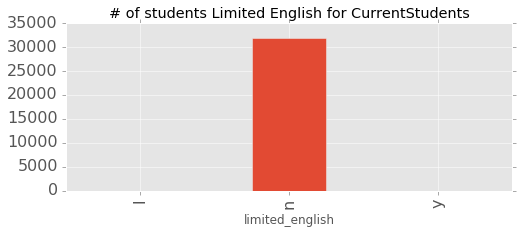

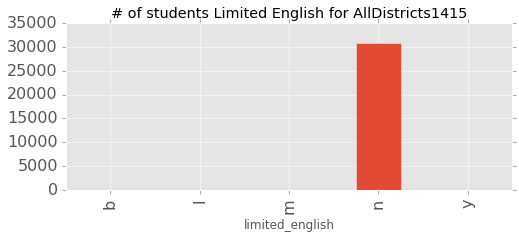

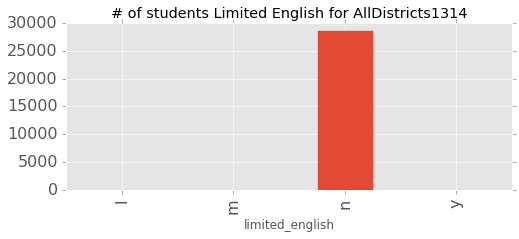

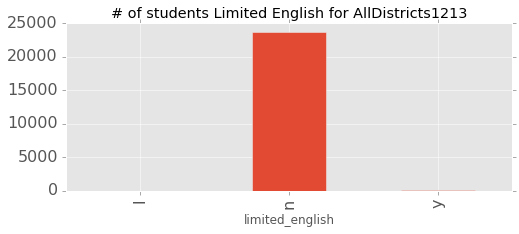

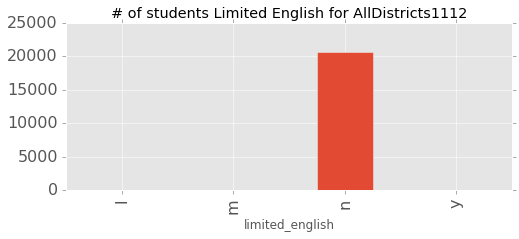

In [16]:
col='LIMITED_ENGLISH'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students Limited English', out_rows=[''], figsize=(8, 3))
    
# what I learnt: maybe not a useful feature 
# Questions: most of them are 'n'
# Cleanup: maybe we don't need this feature

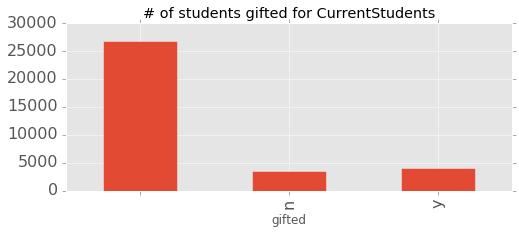

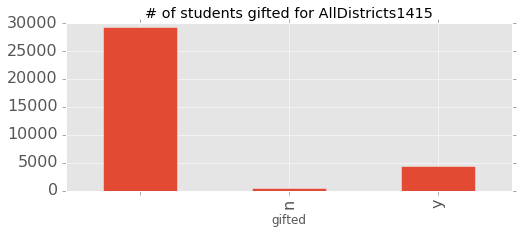

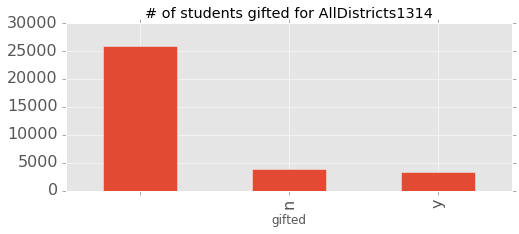

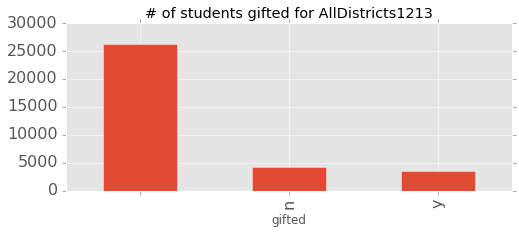

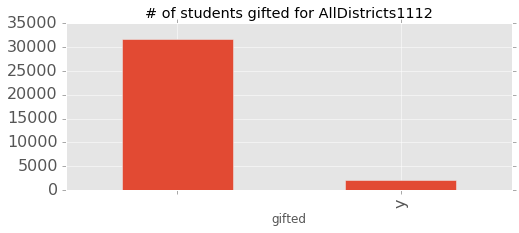

In [17]:
col='GIFTED'
for i in range(5):
    plot_group_counts(ALL_DISTRICTS_TABLES[i], col, title='# of students gifted', out_rows=['abc'], figsize=(8, 3))
    
# what I learnt: ~10% of them are gifted; it could be a feature, only 2 classes
# Questions: blank means 'No'
# Cleanup: blank -> 'n'

In [7]:
def numeric_values_stats_attd_susp(table_index):
    """ statistics of numeric columns in the table 
    
    :param int table_index: index of the table 0, 1, 2, 3, 4
    :return pandas.DataFrame: table with meax, min, mean, num & percentage of NaN
    :rtype pandas.DataFrame
    """
    print("\nTable Name:", ALL_DISTRICTS_TABLES[table_index])
    cols = all_districts_data[table_index].columns[14:-2]
    nRows = all_districts_data[table_index].shape[0]
    stat = [[all_districts_data[table_index][col].max(), all_districts_data[table_index][col].min(), all_districts_data[table_index][col].mean(), all_districts_data[table_index][col].isnull().sum(), 1.0*all_districts_data[table_index][col].isnull().sum()/nRows] for col in cols]
    stat = pd.DataFrame(stat, columns=['max', 'min', 'mean', 'num_of_NaN', 'Percent_NaN'], index=cols)
    return stat
numeric_values_stats_attd_susp(0)


Table Name: CurrentStudents


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2014_15,102.1,0.0,94.658153,5886,0.171469
DAYS_IN_ATTENDANCE_2014_15,193.3,0.0,151.373862,7534,0.219477
DAYS_ABSENT_2014_15,105.5,-0.1,8.160955,5791,0.168701
TARDY_2014_15,66.0,0.0,3.076116,22319,0.650188
PERCENT_ATTEND_2013_14,100.0,0.0,95.150794,10838,0.315728
DAYS_IN_ATTENDANCE_2013_14,205.0,0.0,156.272543,10619,0.309348
DAYS_ABSENT_2013_14,136.5,0.0,7.807099,10639,0.309931
TARDY_2013_14,73.0,0.0,2.007154,12941,0.376992
DISC_INCIDENTS_2014_15,53.0,1.0,3.639384,31016,0.903545
IN_SCHOOL_SUSP_2014_15,8.0,1.0,1.641953,33774,0.983890


In [8]:
numeric_values_stats_attd_susp(1)


Table Name: AllDistricts1415


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2013_14,100.0,0.0,94.616722,7016,0.205742
DAYS_IN_ATTENDANCE_2013_14,205.0,0.0,153.807937,6599,0.193513
DAYS_ABSENT_2013_14,136.5,0.0,8.108844,6772,0.198587
TARDY_2013_14,99.0,0.0,2.161094,9488,0.278232
PERCENT_ATTEND_2012_13,100.2,-20.6,94.954651,10002,0.293305
DAYS_IN_ATTENDANCE_2012_13,176.0,-7.0,160.212924,10032,0.294185
DAYS_ABSENCT_2012_13,84.0,-0.4,8.490708,10370,0.304097
TARDY_2012_13,129.0,0.0,3.106957,16262,0.476878
DISC_INCIDENTS_2013_14,36.0,1.0,3.264346,30912,0.906484
IN_SCHOOL_SUSP_2013_14,28.0,1.0,1.680882,33421,0.980059


In [9]:
numeric_values_stats_attd_susp(2)


Table Name: AllDistricts1314


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2012_13,100.2,-20.6,94.681106,4994,0.150585
DAYS_IN_ATTENDANCE_2012_13,176.0,-7.0,158.652912,4976,0.150042
DAYS_ABSENCE_2012_13,154.6,-0.4,8.916587,5600,0.168858
TARDY_2012_13,129.0,0.0,2.798007,13193,0.397811
PERCENT_ATTEND_2011_12,100.0,-71.9,94.929818,8779,0.264715
DAYS_IN_ATTENDANCE_2011_12,179.5,-12.0,163.041079,11383,0.343234
DAYS_ABSENCE_2011_12,158.5,0.0,8.599667,9287,0.280033
TARDY_2011_12,69.0,0.0,2.626965,16943,0.510885
DISC_INCIDENTS_2012_13,44.0,1.0,3.310822,28470,0.858461
IN_SCHOOL_SUSP_2012_13,12.0,1.0,1.646724,32462,0.978832


In [23]:
numeric_values_stats_attd_susp(3)


Table Name: AllDistricts1213


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2011_12,100.0,-71.9,94.681081,5783,0.169639
DAYS_IN_ATTENDANCE_2011_12,179.5,-14.0,161.891094,8815,0.258580
DAYS_ABSENT_2011_12,158.5,0.0,9.011173,6572,0.192784
TARDY_2011_12,78.0,0.0,2.836480,16349,0.479583
PERCENT_ATTEND_2010_11,100.0,-20.0,94.797354,10752,0.315400
DAYS_IN_ATTENDANCE_2010_11,335.0,-51.0,153.604754,10277,0.301467
DAYS_ABSENT_2010_11,99.5,0.0,8.129651,9956,0.292050
TARDY_2010_11,59.0,0.0,1.849172,11919,0.349633
DISC_INCIDENTS_2011_12,90.0,1.0,4.083865,29392,0.862188
IN_SCHOOL_SUSP_2011_12,20.0,1.0,2.020797,32936,0.966148


In [24]:
numeric_values_stats_attd_susp(4)


Table Name: AllDistricts1112


,max,min,mean,num_of_NaN,Percent_NaN
PERCENT_ATTEND_2010_11,100.0,-166.7,94.537144,7810,0.232281
DAYS_IN_ATTENDANCE_2010_11,179.0,-51.0,153.148846,7502,0.223121
ABSENT_2010_11,107.0,0.0,8.611251,7493,0.222853
TARDY_2010_11,59.0,0.0,2.173397,11062,0.329001
PERCENT_ATTEND_2009_10,100.0,-100.0,94.939437,12705,0.377866
DAYS_IN_ATTENDANCE_2009_10,342.0,-10.0,159.300009,12517,0.372275
ABSENT_2009_10,87.0,0.0,8.437917,12200,0.362847
TARDY_2009_10,58.0,0.0,1.776869,26161,0.778069
DISC_INCIDENTS_2010_11,65.0,1.0,4.502352,30221,0.898819
IN_SCHOOL_SUSP_2010_11,10.0,1.0,1.683566,33051,0.982988


# Deep dive: data exporlation & visuilization 

    1. Current Students' number by grade
    2. Distributions of grades of all students
    3. Grades Comparison of 'dropouts'(no lookup) and other students

### 1. Number of Current Students by (Grade) and (Grade, Gender)

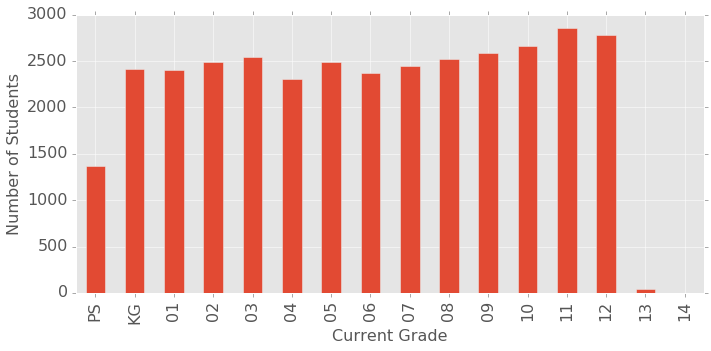

In [10]:
# 1. Current Students' number by grade
col = 'CURRENT_GRADE'
table = 'CurrentStudents'
title = 'Number of students by grade'
figsize = (10, 5)
matplotlib.style.use('ggplot')


df = get_distinct_counts(col, connection, table) # get the counts
col = col.lower() 
df = df.sort_values([col])
df.index = df[col].str.upper()  # get the index 
df = df.loc[df.index[[17, 16] + list(range(14))]] # re-order the index for ploting 
plt.figure()
ax = df['count'].plot(kind='bar', figsize=figsize, fontsize=16)
ax.set_xlabel('Current Grade', fontsize=16)
ax.set_ylabel('Number of Students', fontsize=16)
#ax.set_title("Number of Current Students by Grade", fontsize=16)
plt.tight_layout()
#plt.savefig("Num_Students_byGrade2.png", dpi=300)

/home/jgutman/env/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


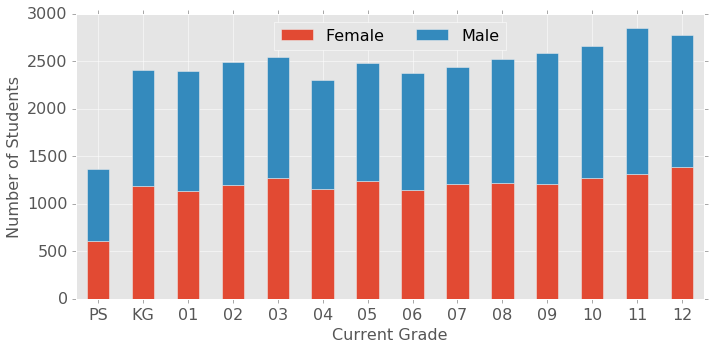

In [11]:
# 1.2 Current Students' number by grade and gender
col1 = 'CURRENT_GRADE'
col2 = 'GENDER'
cmd = "select lower(\"%s\") as %s, upper(left(\"%s\", 1)) as %s, count(*) from \"%s\" \
    where upper(left(\"%s\", 1)) in ('M', 'F') and lower(\"%s\") not in ('gr', '23', '13', '14') \
    group by lower(\"%s\"), left(\"%s\", 1)\
    order by %s, %s" % (col1, col1, col2, col2, table, col2, col1, col1, col2, col1, col2)
df = pd.read_sql(cmd, connection)
df.index = df[col1.lower()].str.upper()  # get the index 


df2 = df.loc[df.gender=='F']
df2['Male'] = df.loc[df.gender=='M', 'count']
df2 = df2.rename(columns={"count": "Female"})
#df2 = df[['current_grade', '']]
df2 = df2[['current_grade', 'Female', 'Male']]
df2 = df2.loc[df2.index[[13, 12] + list(range(12))]] # re-order the index for ploting 
plt.figure()
ax = df2.plot.bar(stacked=True, figsize=figsize, fontsize=16, rot=0);
ax.legend(loc='upper center', ncol=2, fontsize=16)
ax.set_xlabel('Current Grade', fontsize=16)
ax.set_ylabel('Number of Students', fontsize=16)
#ax.set_title("Number of Current Students by Grade and Gender", fontsize=16)
plt.tight_layout()
plt.savefig("./figures/Num_Students_byGradeGender2.png", dpi=500)

In [179]:
df2

,current_grade,Female,Male
current_grade,,,
01,01,1140,1260
02,02,1195,1294
03,03,1272,1270
04,04,1154,1154
05,05,1245,1243
06,06,1142,1232
07,07,1205,1241
08,08,1224,1300
09,09,1211,1380


### 2. Distribution of Grades of all students

In [30]:
# Distinct number of students
def distinct_count_HSGrade(col, connection):
    df = pd.read_sql("select count(distinct \"%s\") from \"HSGrades\";" % col, connection)
    print("Number of unique %s: " % col, df.iloc[0,0])

print("Number of all rows: ", 247417)
distinct_count_HSGrade("StudentLookup", connection);
distinct_count_HSGrade("Ctr", connection);
distinct_count_HSGrade("Grade", connection);
distinct_count_HSGrade("CourseCode", connection);
distinct_count_HSGrade("FinalMark", connection);
distinct_count_HSGrade("SchoolYear", connection);


Number of all rows:  247417
Number of unique StudentLookup:  13755
Number of unique Ctr:  246756
Number of unique Grade:  11
Number of unique CourseCode:  4696
Number of unique FinalMark:  3584
Number of unique SchoolYear:  6


In [166]:
# count of top 10 courses that are most taken by students
df = pd.read_sql("select \"CourseCode\", count(*) as cnt from \"HSGrades\" group by \"CourseCode\" order by cnt desc limit 10;" , connection)
df

,CourseCode,cnt
0,454,1550
1,110,1433
2,312,1337
3,467,1161
4,902,1103
5,815,1087
6,215,1077
7,210,1073
8,901,1038
9,1209,1006


#### 2.1. Grades Distribution of all students and all courses

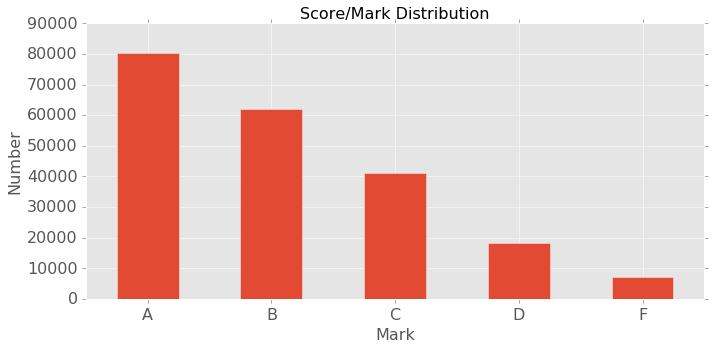

In [32]:
# Final Mark Distribution 
cmd = "select left(\"FinalMark\", 1) as Mark, count(*) as cnt from \"HSGrades\" \
     where left(\"FinalMark\", 1) ~* '[A-Z]' group by left(\"FinalMark\", 1) order by cnt desc limit 20;"
df = pd.read_sql(cmd, connection)
df.index = df.mark
plt.figure()
ax = df.iloc[:5, :].plot.bar(figsize=figsize, fontsize=16, rot=0)
ax.legend_.remove()
ax.set_xlabel('Mark', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
ax.set_title("Score/Mark Distribution", fontsize=16)
plt.tight_layout()
#plt.savefig("All_Mark_Distribution.png", dpi=300)

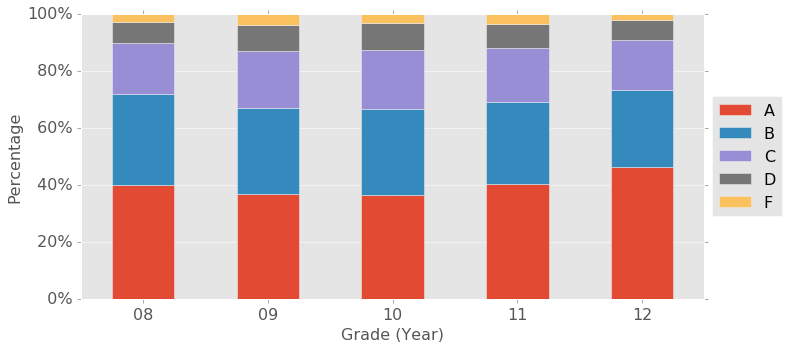

In [12]:
# Final Mark Percentage Distribution by Grade
cmd = "select left(\"FinalMark\", 1) as Mark, \"Grade\", count(*) as cnt from \"HSGrades\" \
     where left(\"FinalMark\", 1) in ('A', 'B', 'C', 'D', 'F') and \"Grade\" in ('08','09', '10', '11', '12') \
     group by left(\"FinalMark\", 1), \"Grade\" order by \"Grade\", Mark;"
df2 = pd.read_sql(cmd, connection)

grades = np.unique(df2.Grade)
rot_table = []
for g in grades:
    cnts = list(df2.cnt[df2.Grade==g])
    rot_table.append([g] + cnts)
    
df2 = pd.DataFrame(rot_table, columns=['Grade', 'A', 'B', 'C', 'D', 'F'])
df2.index = df2.Grade

rowsums = np.array(df2.iloc[:,1:]).sum(axis=1)
for i in range(len(rowsums)):
    df2.iloc[i, 1:] = (1.*df2.iloc[i, 1:]/rowsums[i])
    
plt.figure()
ax = df2.plot.bar(stacked=True, figsize=figsize, fontsize=16, rot=0);
lgd=ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  ncol=1, fontsize=16)
ax.set_xlabel('Grade (Year)', fontsize=16)
ax.set_ylabel('Percentage', fontsize=16)
ax.set_ylim([0, 1])
ax.set_yticklabels(['{:3.0f}%'.format(x*20) for x in range(6)])
#ax.set_title("Percentage of Letter Grades by Grade", fontsize=16)
plt.tight_layout()
plt.savefig("./figures/Grade8to12_Mark_Distribution2.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=500)

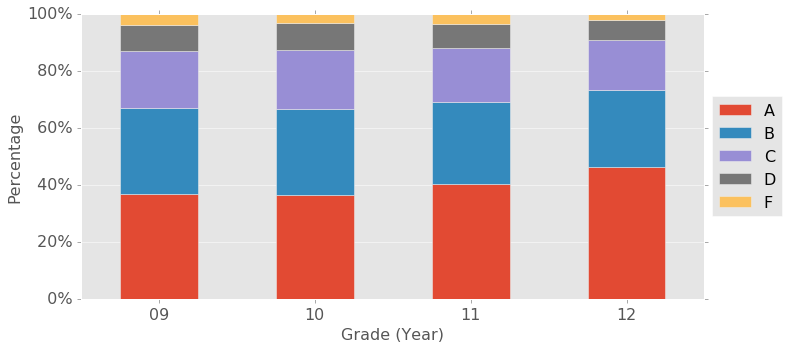

In [17]:
# Final Mark Percentage Distribution by Grade
cmd = "select left(\"FinalMark\", 1) as Mark, \"Grade\", count(*) as cnt from \"HSGrades\" \
     where left(\"FinalMark\", 1) in ('A', 'B', 'C', 'D', 'F') and \"Grade\" in ('09', '10', '11', '12') \
     group by left(\"FinalMark\", 1), \"Grade\" order by \"Grade\", Mark;"
df2 = pd.read_sql(cmd, connection)

grades = np.unique(df2.Grade)
rot_table = []
for g in grades:
    cnts = list(df2.cnt[df2.Grade==g])
    rot_table.append([g] + cnts)
    
df2 = pd.DataFrame(rot_table, columns=['Grade', 'A', 'B', 'C', 'D', 'F'])
df2.index = df2.Grade

rowsums = np.array(df2.iloc[:,1:]).sum(axis=1)
for i in range(len(rowsums)):
    df2.iloc[i, 1:] = (1.*df2.iloc[i, 1:]/rowsums[i])
    
plt.figure()
ax = df2.plot.bar(stacked=True, figsize=figsize, fontsize=16, rot=0);
lgd=ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  ncol=1, fontsize=16)
ax.set_xlabel('Grade (Year)', fontsize=16)
ax.set_ylabel('Percentage', fontsize=16)
ax.set_ylim([0, 1])
ax.set_yticklabels(['{:3.0f}%'.format(x*20) for x in range(6)])
#ax.set_title("Percentage of Letter Grades by Grade", fontsize=16)
plt.tight_layout()
#plt.savefig("./figures/Grade8to12_Mark_Distribution3.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=500)

### 2. Comparison between 2 group of students: no Lookup # and having Lookup #

In [62]:
pd.Series(all_districts_data[1].columns)

0                  StudentLookup
1                  CURRENT_GRADE
2                       HANDICAP
3                  HANDICAP_DESC
4               DISADVANTAGEMENT
5          DISADVANTAGEMENT_DESC
6                  DATE_OF_BIRTH
7                 STUDENT_STATUS
8            STUDENT_STATUS_DESC
9                         GENDER
10            RACIAL_ETHNIC_DESC
11               LIMITED_ENGLISH
12                        GIFTED
13                ADMISSION_DATE
14        PERCENT_ATTEND_2013_14
15    DAYS_IN_ATTENDANCE_2013_14
16           DAYS_ABSENT_2013_14
17                 TARDY_2013_14
18        PERCENT_ATTEND_2012_13
19    DAYS_IN_ATTENDANCE_2012_13
20          DAYS_ABSENCT_2012_13
21                 TARDY_2012_13
22        DISC_INCIDENTS_2013_14
23        IN_SCHOOL_SUSP_2013_14
24    OUT_OF_SCHOOL_SUSP_2013_14
25                 EXPUL_2013_14
26                      District
27                        School
dtype: object

In [148]:
def compare_null_high_school_group(tab_ind, col_ind):
    """ calculate mean and std between the null-StudentLookup and not-null high school students group 
    
    :param int tab_ind: index of table, 1, 2, 3, 4
    :param int col_ind: index of column number, 14 for attend, 22 for disc
    :return list of mean and std: mean1, mean2, std1, std2
    :rtype: list
    """
    all_grades = ['07', '12', '09', '01', '04', 'KG', '02', '06', '05', '03', '10', 'PS', '11', '08', '23', '13', '14']
    selected_grades = ['11', '12'] 
    
    colname = all_districts_data[tab_ind].columns[col_ind]
    null_index = np.isnan(all_districts_data[tab_ind].StudentLookup)
    notnull_index = ~ null_index
    null_highschool_index = np.logical_and(pd.Series([x in selected_grades for x in all_districts_data[tab_ind].CURRENT_GRADE]), null_index)
    notnull_highschool_index = np.logical_and(pd.Series([x in selected_grades for x in all_districts_data[tab_ind].CURRENT_GRADE]), notnull_index)

    means_stds = [0]*4; # [mean1, mean2, std1, std2]
    means_stds[0] = all_districts_data[tab_ind][notnull_highschool_index].iloc[:, col_ind].mean()
    means_stds[1] = all_districts_data[tab_ind][null_highschool_index].iloc[:, col_ind].mean()
    means_stds[2] = all_districts_data[tab_ind][notnull_highschool_index].iloc[:, col_ind].std()
    means_stds[3] = all_districts_data[tab_ind][null_highschool_index].iloc[:, col_ind].std()
    return means_stds


       Graduated  Not Graduated      Std1       Std2
10_11  94.689676      92.162515  5.112913  14.705588
11_12  94.746947      91.488960  5.421166   8.632686
12_13  94.835183      90.517111  4.745506   9.091882
14_15  93.794595      87.822273  9.241086  13.872692


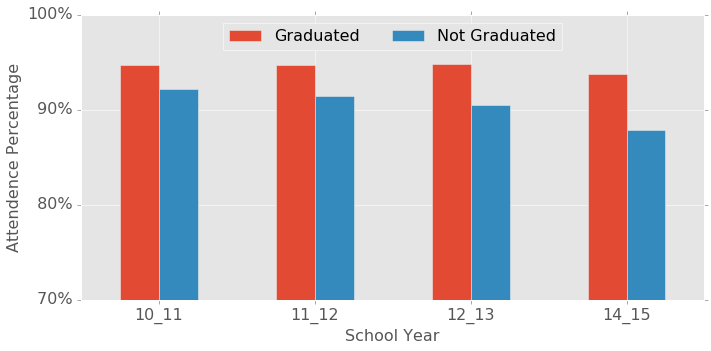

In [175]:
colnames = ["Graduated", "Not Graduated", 'Std1', 'Std2']
indcies = ['10_11', '11_12', '12_13', '14_15']
attend_cmp = [compare_null_high_school_group(i, 14) for i in range(4,0, -1)]
attend_cmp = pd.DataFrame(attend_cmp, index=indcies, columns=colnames)
print(attend_cmp)
plt.figure()
ax = attend_cmp.iloc[:, :2].plot.bar(figsize=figsize, fontsize=16, rot=0);
lgd=ax.legend(loc='upper center',  ncol=2, fontsize=16)
ax.set_xlabel('School Year', fontsize=16)
ax.set_ylabel('Attendence Percentage', fontsize=16)
ax.set_yticks([70, 80, 90, 100])
ax.set_yticklabels(['{:3.0f}%'.format(x*10) for x in range(7, 11)])
ax.set_ylim([70, 100])
#ax.set_yticklabels(['{:3.0f}%'.format(x*20) for x in range(6)])
#ax.set_title("Attendence", fontsize=16)
plt.tight_layout()
plt.savefig("./figures/Grade11to12_AttdPercent.png", bbox_inches='tight', dpi=500)

       Graduated  Not Graduated      Std1      Std2
10_11   5.074689       6.411458  6.919701  8.215199
11_12   4.397978       5.660287  6.277006  7.133493
12_13   3.303318       5.198020  4.085767  5.818631
14_15   3.388043       5.490000  3.927314  6.629434


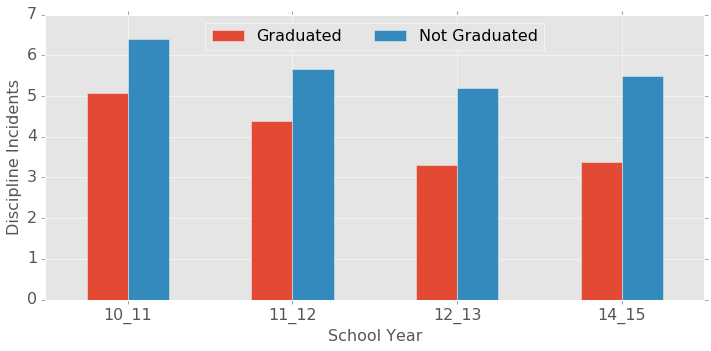

In [176]:
colnames = ["Graduated", "Not Graduated", 'Std1', 'Std2']
indcies = ['10_11', '11_12', '12_13', '14_15']
disc_cmp = [compare_null_high_school_group(i, 22) for i in range(4, 0, -1)]
disc_cmp = pd.DataFrame(disc_cmp, index=indcies, columns=colnames)
print(disc_cmp)
plt.figure()
ax = disc_cmp.iloc[:, :2].plot.bar(figsize=figsize, fontsize=16, rot=0);
lgd=ax.legend(loc='upper center',  ncol=2, fontsize=16)
ax.set_xlabel('School Year', fontsize=16)
ax.set_ylabel('Discipline Incidents', fontsize=16)
#ax.set_ylim([50, 100])
#ax.set_yticklabels(['{:3.0f}%'.format(x*20) for x in range(6)])
#ax.set_title("Attendence", fontsize=16)
plt.tight_layout()
plt.savefig("./figures/Grade11to12_DiscIncidents.png", bbox_inches='tight', dpi=500)

         Group1    Group2      Std1       Std2
10_11  2.588850  4.010689  4.457961   5.758198
11_12  3.489309  4.295455  4.651032   6.309201
12_13  3.411035  8.259669  6.936844  11.992647
14_15  3.486826  3.847162  6.475573   7.851598


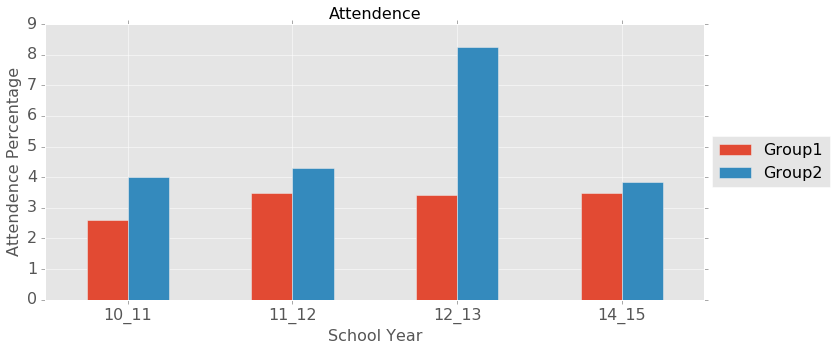

In [156]:
colnames = ["Group1", "Group2", 'Std1', 'Std2']
indcies = ['10_11', '11_12', '12_13', '14_15']
disc_cmp = [compare_null_high_school_group(i, 17) for i in range(4, 0, -1)]
disc_cmp = pd.DataFrame(disc_cmp, index=indcies, columns=colnames)
print(disc_cmp)
plt.figure()
ax = disc_cmp.iloc[:, :2].plot.bar(figsize=figsize, fontsize=16, rot=0);
lgd=ax.legend(loc='upper center', ncol=1, fontsize=16)
ax.set_xlabel('School Year', fontsize=16)
ax.set_ylabel('Attendence Percentage', fontsize=16)
#ax.set_ylim([50, 100])
#ax.set_yticklabels(['{:3.0f}%'.format(x*20) for x in range(6)])
ax.set_title("Tady", fontsize=16)
plt.tight_layout()